<a href="https://colab.research.google.com/github/titan-adi/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

def imshow(img, title=None):
    if len(img.shape) > 3:
        img = tf.squeeze(img, axis=0)
    plt.imshow(img)
    if title:
        plt.title(title)

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def get_model():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                    'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']
    output_layers = style_layers + content_layers
    model = tf.keras.Model([vgg.input], [vgg.get_layer(name).output for name in output_layers])
    return model


In [ ]:
def gram_matrix(input_tensor):
   if len(input_tensor.shape) == 3:
    input_tensor = tf.expand_dims(input_tensor, axis=0)
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

In [ ]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:5]]
    content_features = [content_layer[0] for content_layer in content_outputs[5:]]
    return style_features, content_features

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:5]
    content_output_features = model_outputs[5:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(len(gram_style_features))
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_matrix(comb_style) - target_style))

    weight_per_content_layer = 1.0 / float(len(content_features))
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content - target_content))

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
def apply_style_transfer(content_image, style_image, num_iterations=1000):
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
    return stylized_image

In [ ]:

def style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):

    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = load_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    iter_count = 1
    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            stylized_image = deprocess_img(init_image.numpy())

        if i % 100 == 0:
            print(f"Iteration: {i}, Total loss: {loss:.4e}, "
                  f"Style loss: {style_score:.4e}, Content loss: {content_score:.4e}")

    return stylized_image

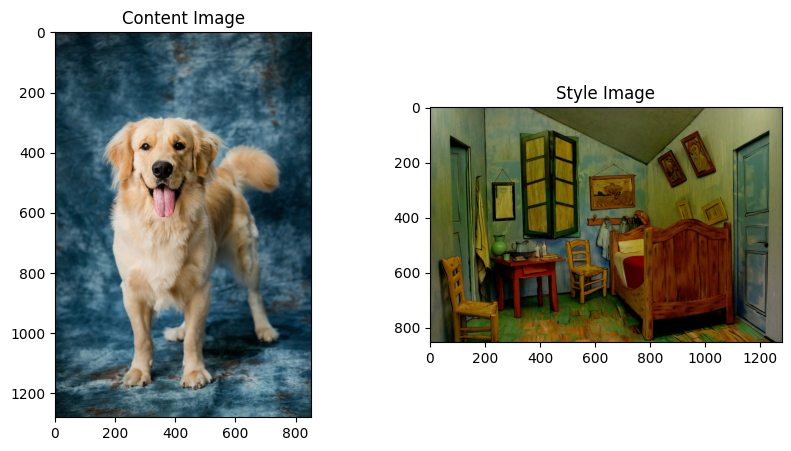

In [ ]:

# Path to your style and content images
content_path = 'content.jpg'
style_path = 'style.jpg'

# Load images
content_image = load_img(content_path)
style_image = load_img(style_path)

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

plt.show()


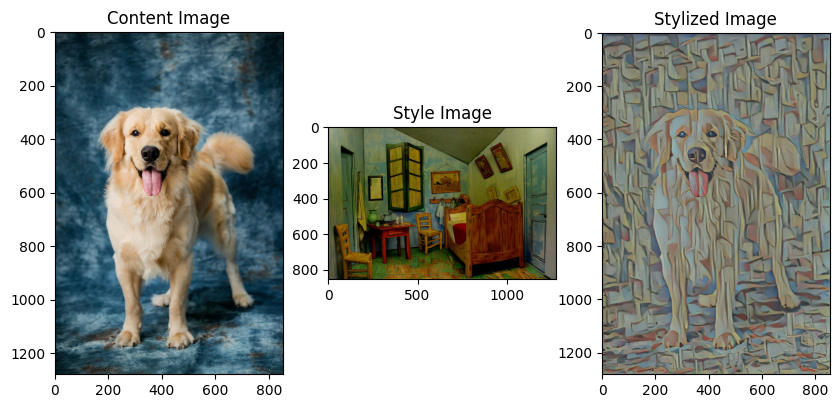

In [ ]:
# Apply style transfer
stylized_image = apply_style_transfer(content_image, style_image)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image')

plt.subplot(1, 3, 3)
imshow(stylized_image, 'Stylized Image')

plt.show()